# 04. PyTorch Custom Dataset

Kita sudah menggunakan beberapa dataset dengan pytorch before

Tetapi bagaiman jika kita ingin menggunakan data sendiri

Salah satu cara untuk melakukannya: Dataset kustom

## Domain Libraries

Bergantung pada apa yang kamu kerjakan, citra, teks, audio, kamu akan melihat tiap PyTorch domain libraries untuk data yang sudah ada berdasarkan fungsi dan kustom data loader

# 0. Import PyTorch dan setup agnostic device

In [4]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu124'

In [5]:
# Setup perangkat agnostik
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
device

'cpu'

## 1. Ambil Data

Dataset kita adalah subset dari Food101 Dataset

Food101 dimulai dari 101 kelas berbeda dari makanan (750 Training, 250 Testing)

Dataset kita dimulai dari 3 kelas dan hanya 10% dari gambar (75 Training, 25 Testing)

Ketika mencoba pembelajaran mesil, ini adalah hal penting untuk melakukan dari kecil lalu meningkatkannya ketika dibutuhkan.

Intinya adalah seberapa cepat kita dapat bereksperiment

In [7]:
import requests
import zipfile
from pathlib import Path

# Buat jalur untuk folder data
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Jika folder gambar tidak ada, download dan siapkan
if image_path.is_dir():
  print(f"{image_path} direktori sudah ada...")
else:
  print(f"{image_path} belum ada, membuat...")
  image_path.mkdir(parents=True, exist_ok=True)

data/pizza_steak_sushi belum ada, membuat...


In [8]:
# Unduh pizza, steak, dan sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak sushi data")
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping data")
  zip_ref.extractall(image_path)

Unzipping data


## 2. Menjadi satu dengan data (preparasi data, dan eksplorasi data)

In [9]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"Ada {len(dirnames)} direktori dan {len(filenames)} gambar didalam '{dirpath}'.")

In [10]:
walk_through_dir(image_path)

Ada 2 direktori dan 0 gambar didalam 'data/pizza_steak_sushi'.
Ada 3 direktori dan 0 gambar didalam 'data/pizza_steak_sushi/train'.
Ada 0 direktori dan 72 gambar didalam 'data/pizza_steak_sushi/train/sushi'.
Ada 0 direktori dan 78 gambar didalam 'data/pizza_steak_sushi/train/pizza'.
Ada 0 direktori dan 75 gambar didalam 'data/pizza_steak_sushi/train/steak'.
Ada 3 direktori dan 0 gambar didalam 'data/pizza_steak_sushi/test'.
Ada 0 direktori dan 31 gambar didalam 'data/pizza_steak_sushi/test/sushi'.
Ada 0 direktori dan 25 gambar didalam 'data/pizza_steak_sushi/test/pizza'.
Ada 0 direktori dan 19 gambar didalam 'data/pizza_steak_sushi/test/steak'.


In [11]:
# Setup alur latih dan tes

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.1 Visualisasikan Gambar

Yang akan kita buat
1. Ambil semua path gambar
2. Ambil gambar acak dengan random.choice()
3. Ambil kelas gamabr dengan `pathlib.Path.parent.stem`
4. Sejak kta bekerja dengan gambar, kita akan membuka gambar dengan PIL (pillow)
5. Kita akan menunjukkan gambar dan memberikan metadatanya

In [50]:
import random

# Set seed
# random.seed(42)

# 1. Ambil jalur gambar
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pilih jalur gambar secara acak
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Ambil kelas dari pathname (kelas gambar diambil dari direktori dimana gambarnya disimpan)
image_class = random_image_path.parent.stem
print(image_class)

data/pizza_steak_sushi/train/sushi/3360232.jpg
sushi


Random image path: data/pizza_steak_sushi/train/sushi/3360232.jpg
Image class: sushi
Image height: 384
Image width: 512


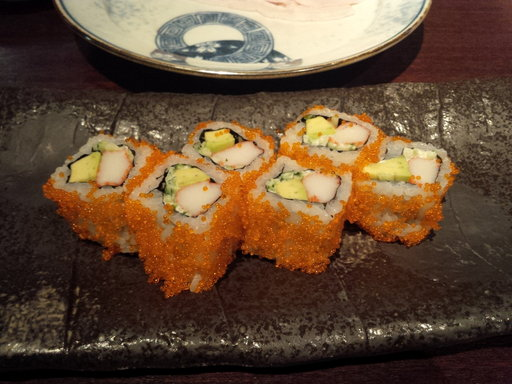

In [51]:
from PIL import Image

# 4. Buka gambar
img = Image.open(random_image_path)

# 5. Berikan metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 383.5, -0.5)

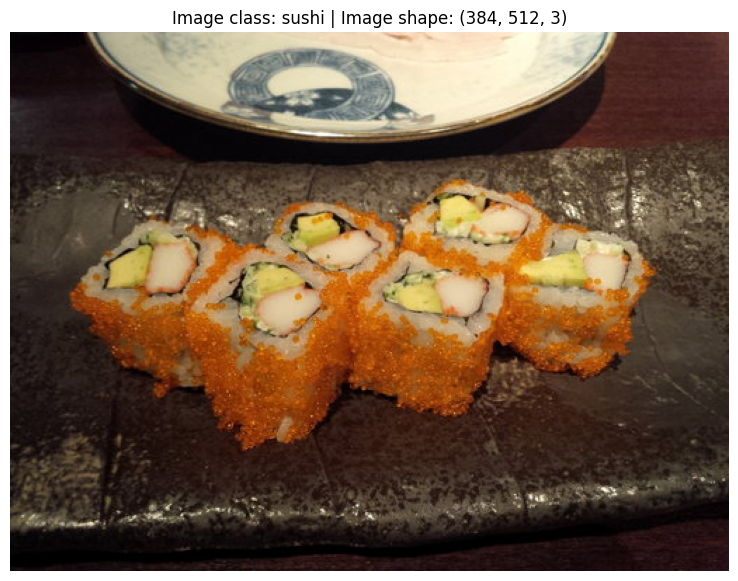

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Ubah image ke array
img_as_array = np.asarray(img)

# Plot gambar
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)

## 3. Mengubah data

Sebelum kita dapat menggunakan gambar kita dengan PyTorch:
1. Ubah target data menjadi bentuk tensor (numerical representation dari gambar kita)
2. Ubah itu menjadi `torch.utils.data.Dataset` dan kemudian ubah menjadi `torch.utils.data.DataLoader` (untuk dibuatkan batch nya)

In [53]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data dengan `torchvision.transforms`

Transform membantu gambar anda untuk bisa digunakan dengan model

In [54]:
# Buatkan transform untuk gambar
data_transform = transforms.Compose([
    # Resize gambar kita ke 64*64
    transforms.Resize(size=(64,64)),

    # Balikkan gambar secara acak dengan horizontal
    transforms.RandomHorizontalFlip(p=0.5),

    # Ubah gambar menjadi torch.Tensor
    transforms.ToTensor()
])

In [60]:
data_transform(img)[:2]

tensor([[[0.0196, 0.0196, 0.0196,  ..., 0.3294, 0.3647, 0.3882],
         [0.0196, 0.0196, 0.0235,  ..., 0.3098, 0.3373, 0.3725],
         [0.0392, 0.0431, 0.0471,  ..., 0.3098, 0.3294, 0.3529],
         ...,
         [0.0235, 0.0196, 0.0235,  ..., 0.1490, 0.1569, 0.1608],
         [0.0039, 0.0039, 0.0039,  ..., 0.1373, 0.1569, 0.1490],
         [0.0353, 0.0275, 0.0314,  ..., 0.1373, 0.1490, 0.1451]],

        [[0.0118, 0.0118, 0.0118,  ..., 0.1843, 0.2039, 0.2275],
         [0.0039, 0.0039, 0.0039,  ..., 0.1647, 0.1804, 0.2078],
         [0.0196, 0.0196, 0.0196,  ..., 0.1608, 0.1765, 0.2000],
         ...,
         [0.0157, 0.0118, 0.0157,  ..., 0.0667, 0.0667, 0.0667],
         [0.0039, 0.0039, 0.0039,  ..., 0.0588, 0.0706, 0.0627],
         [0.0196, 0.0118, 0.0118,  ..., 0.0549, 0.0667, 0.0627]]])

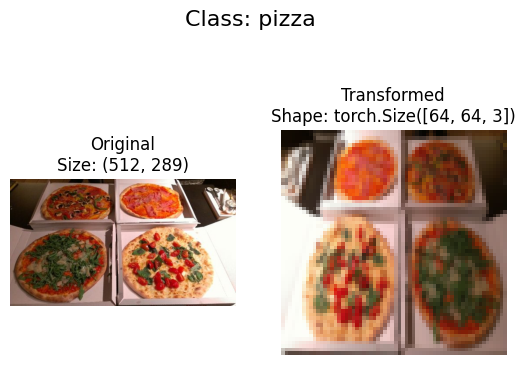

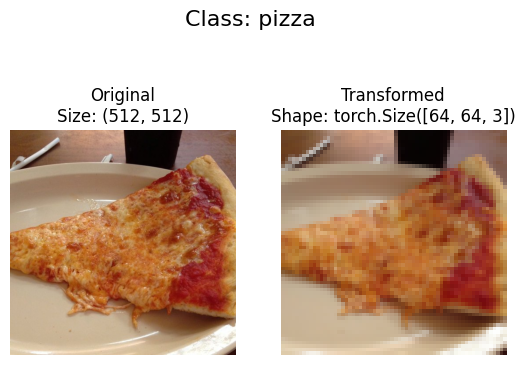

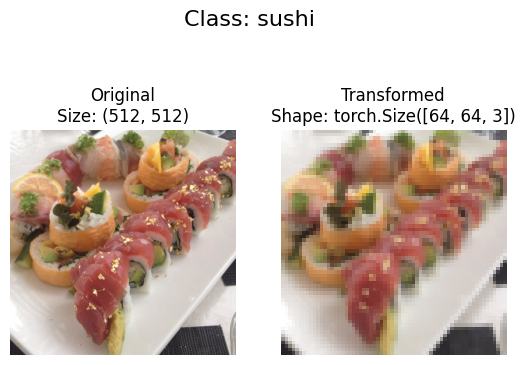

In [66]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target gambar
      transformed_image = transform(f).permute(1, 2, 0) # Kita akan ubah bentuk untuk matplotlib
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)


## 4. Opsi 1: Muat data gambar dengan `ImageFolder`

Kita bisa muat klasifikasi gambar dengan menggunakan `torchvision.datasets.ImageFolder`

In [67]:
# Gunakan ImageFolder untuk membuat dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [68]:
# Ambil nama kelas dengan list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [69]:
# Ambil nama kelas sebagai dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [70]:
# Cek panjang dari dataset
len(train_data), len(test_data)

(225, 75)

In [76]:
train_data.samples[:5], train_data.targets[:5]

([('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
  ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
  ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
  ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
  ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0)],
 [0, 0, 0, 0, 0])

In [81]:
# Index didalam train_data dataset untuk mendapatkan satu gambar
img, label = train_data[0][0], train_data[0][1]
img, class_names[label]
print(f"Gambar tenspr:\n {img[:2]}")
print(f"Bentuk gambar:\n {img.shape}")
print(f"Gambar datatype: \n {img.dtype}")
print(f"Label gambar: \n {label}")
print(f"Label gambar: \n {type(label)}")

Gambar tenspr:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]]])
Bentuk gambar:
 torch.Size([3, 64, 64])
Gambar datatype: 
 torch.float32
Label gambar: 
 0
Label gambar: 
 <class 'int'>


Bentuk asli: torch.Size([3, 64, 64]) -> [C, H, W]
Permutasi Gambar: torch.Size([64, 64, 3]) -> [H, W, C]


Text(0.5, 1.0, 'pizza')

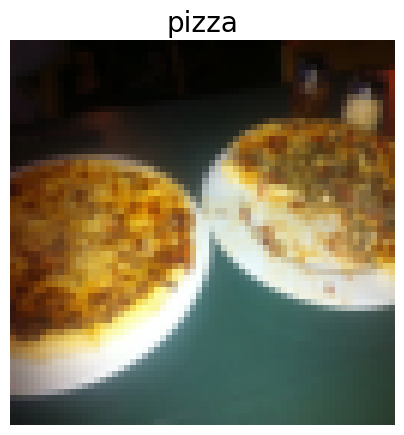

In [84]:
# Mengatur ulang dimensi -> [H, W, C]
img_permute = img.permute(1,2,0)

# Lihatkan shape berbeda
print(f"Bentuk asli: {img.shape} -> [C, H, W]")
print(f"Permutasi Gambar: {img_permute.shape} -> [H, W, C]")

# Plot gambar
plt.figure(figsize=(5,5))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=20)

## 4.1 Ubah gambar termuat menjadi `DataLoader`

Sebuah `DataLoader` akan membantu kita mengubah dataset menjadi iterable dan kita dapat mengkostumisasi `batch_size` jadi model kita dapat melihat `batch_size` gambar dalam satu waktu